# Stackoverflow data

## Init

### Imports

In [1]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from hd_utils import monitor
from nltk.corpus import stopwords
from html.parser import HTMLParser
from sklearn.datasets.lfw import Bunch
from html_preprocessing import HTMLPreprocessor

### Plot

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [3]:
args = Bunch()

## Read

In [4]:
args.data_kaggle_name = 'pythonquestions'
args.len_up = 10000

In [5]:
!kaggle datasets download -d stackoverflow/$args.data_kaggle_name

pythonquestions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
_base_path = f'~/.kaggle/datasets/stackoverflow/{args.data_kaggle_name}'
questions_path = os.path.join(_base_path, 'Questions.csv')
tags_path = os.path.join(_base_path, 'Tags.csv')

In [7]:
%time qdf = pd.read_csv(questions_path, encoding='ISO-8859-1')
qdf.shape

CPU times: user 12.3 s, sys: 860 ms, total: 13.1 s
Wall time: 13.1 s


(607282, 6)

In [8]:
qdf.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [25]:
qdf.drop(['OwnerUserId', 'CreationDate', 'Score'], axis=1, inplace=True)
qdf.rename({c: c.lower() for c in qdf.columns}, axis=1, inplace=True)
qdf = qdf[qdf.body.map(len) <= args.len_up].copy()
qdf.shape

ValueError: labels ['OwnerUserId' 'CreationDate' 'Score'] not contained in axis

In [26]:
qdf.head()

,id,title,body
0,469,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


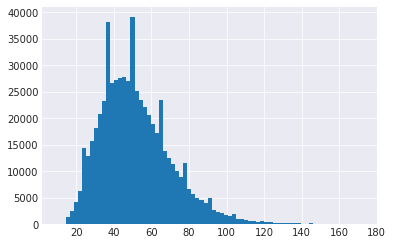

In [10]:
qdf.title.map(len).hist(bins=75);

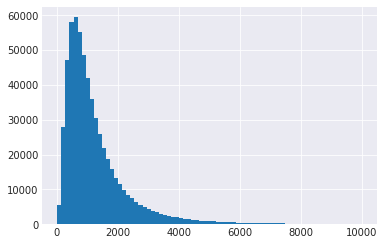

In [11]:
qdf.body.map(len).hist(bins=75);

## Text

In [12]:
args.log_step = 5000

In [13]:
sample = qdf.body.sample().iloc[0]
sample, HTMLPreprocessor(do_tqdm=False).fit_transform([sample])[0]

('<p>I need help on minimizing function in python using three variable constraints. </p>\n\n<p>I have posted the code which is giving me error. If you would like I can post the entire code to to show the mathematical calculation.:</p>\n\n<pre><code># the time-series data.\ncoeff = [0.2, 0.3, 0.4]\n\nx =[146, 96, 59, 133, 192, 127, 79, 186, 272, 155, 98, 219]\ntest = y(x,coeff)\nprint("x : ", x)\nprint("y : ",test)\n\nresult = minimize(mape, coeff, (x,), bounds =[(0,1),(0,1), (0,1)], method=\'SLSQP\')\n\nopt = result.x\nprint("opt : ", result.x)\n</code></pre>\n\n<p>This is my code:</p>\n\n<pre><code>from __future__ import division\nimport numpy as np\nfrom scipy.optimize import minimize\n\n\n\n#coeffList[0] = alpha\n#coeffList[1] = beta\n#coeffList[2] =gamma\n\ndef mape(x, coeffList):\n    diff = abs(y(x,coeffList)-x)\n    print("np.mean(diff/x) : ", np.mean(diff/x))\n    return np.mean(diff/x)\n\n\n#Holt Winters-Multiplicative\n\n\n\ndef y(x, coeffList , debug=True):\n\n    c =4 \n   

In [14]:
preprocessor = HTMLPreprocessor(
    monitor=monitor('[1.6.1] Bodies filtering', log_step=args.log_step, log_total=len(qdf))
)
bodies = preprocessor.fit_transform(qdf.body)

100%|██████████| 604502/604502 [27:55<00:00, 360.82it/s]


In [15]:
text = [t + ' DCNL ' + b for t, b in zip(qdf.title, bodies)]
df = pd.DataFrame(text, columns=['text'])
df.head()

,text
0,How can I find the full path to a font from it...
1,Get a preview JPEG of a PDF on Windows? DCNL I...
2,Continuous Integration System for a Python Cod...
3,cx_Oracle: How do I iterate over a result set?...
4,Using 'in' to match an attribute of Python obj...


## Tags

In [16]:
tdf = pd.read_csv(tags_path, encoding='latin1')
tdf.shape

(1885078, 2)

In [17]:
tdf.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [18]:
tdf.rename({c: c.lower() for c in tdf.columns}, axis=1, inplace=True)
tdf.head()

,id,tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [19]:
len(tdf.tag.unique())

16896

In [20]:
tdf.tag.value_counts()[:20]

python               607282
django                62818
python-2.7            34616
pandas                26854
python-3.x            26814
numpy                 25848
list                  18951
matplotlib            16521
regex                 14047
dictionary            13413
tkinter               10766
string                10616
flask                 10488
google-app-engine     10286
csv                    9323
arrays                 9170
json                   8023
mysql                  7529
linux                  7121
html                   7118
Name: tag, dtype: int64

In [21]:
@monitor('[1.6.2] Join tags', log_step=args.log_step, log_total=len(tdf))
def join_tags(df, *, log):
    df = df.copy()
    tags = [[] for _ in range(len(df))]
    id2i = dict(zip(qdf.id, qdf.index))
    for i, (_, (id_, tag)) in enumerate(tqdm(tdf.iterrows(), total=len(tdf))):
        if id_ in id2i:
            tags[id2i[id_]].append(tag)
        log.istep(i)
    df['tags'] = [' '.join(sorted(id_tags)) for id_tags in tags]
    return df

In [22]:
df = join_tags(df)
del qdf
del tdf
df.shape

  1%|          | 13254/1885073 [00:02<05:32, 5625.01it/s]


KeyError: 788084

In [ ]:
df.head()

## Save

In [ ]:
args.data_path = 'stackoverflow_data.hdf5'

In [ ]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='t', complevel=9)

In [ ]:
!du -sh $args.save_path

## End

In [ ]:
args